# Stress and Rest Label Creation Using Event Tags

This notebook creates stress and rest labels from wearable EDA data by using event tag timestamps. The signal is segmented into time intervals and labeled to prepare the data for feature extraction.

In [8]:
# basic libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [9]:
# dataset path
BASE_PATH = r"C:\Users\KARAN\Downloads\Internship Project\Wearable_Dataset\Wearable_Dataset"

# stress folder
STRESS_PATH = os.path.join(BASE_PATH, "STRESS")

# choose subject manually (use the one that worked in 01_explore)
subject = "S01"   # <-- change if your subject is different

# subject folder path
SUBJECT_PATH = os.path.join(STRESS_PATH, subject)

print("Using subject:", subject)
print("Files:", os.listdir(SUBJECT_PATH))


Using subject: S01
Files: ['ACC.csv', 'BVP.csv', 'EDA.csv', 'HR.csv', 'IBI.csv', 'tags.csv', 'TEMP.csv']


In [10]:
# load EDA.csv
eda_path = os.path.join(SUBJECT_PATH, "EDA.csv")
eda_raw = pd.read_csv(eda_path, header=None)

# start time can be unix OR datetime string
start_raw = str(eda_raw.iloc[0, 0]).strip()

try:
    start_time = pd.to_datetime(float(start_raw), unit="s", utc=True)
except:
    start_time = pd.to_datetime(start_raw, utc=True)

# sampling rate
fs = float(eda_raw.iloc[1, 0])

# EDA values
eda_values = eda_raw.iloc[2:, 0].astype(float).values

# time axis
time_axis = start_time + pd.to_timedelta(np.arange(len(eda_values)) / fs, unit="s")

# dataframe
eda_df = pd.DataFrame({"time": time_axis, "eda": eda_values})

print("EDA loaded | fs =", fs)
eda_df.head()


EDA loaded | fs = 4.0


,time,eda
0,2013-02-20 17:55:19+00:00,0.000000
1,2013-02-20 17:55:19.250000+00:00,0.005125
2,2013-02-20 17:55:19.500000+00:00,0.001281
3,2013-02-20 17:55:19.750000+00:00,0.006407
4,2013-02-20 17:55:20+00:00,0.006407


In [11]:
# load tags.csv
tags_path = os.path.join(SUBJECT_PATH, "tags.csv")
tags_raw = pd.read_csv(tags_path, header=None)

# convert to datetime safely
tag_times = []
for x in tags_raw[0].astype(str):
    x = x.strip()
    try:
        tag_times.append(pd.to_datetime(float(x), unit="s", utc=True))
    except:
        tag_times.append(pd.to_datetime(x, utc=True))

tag_times = pd.to_datetime(tag_times)

print("Total tags:", len(tag_times))
tag_times[:10]


Total tags: 13


DatetimeIndex(['2013-02-20 18:01:30+00:00', '2013-02-20 18:05:37+00:00',
               '2013-02-20 18:08:32+00:00', '2013-02-20 18:10:17+00:00',
               '2013-02-20 18:17:37+00:00', '2013-02-20 18:19:42+00:00',
               '2013-02-20 18:24:49+00:00', '2013-02-20 18:25:17+00:00',
               '2013-02-20 18:25:55+00:00', '2013-02-20 18:26:32+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)

In [12]:
# create segments between tags
# idea: between tag0-tag1 = rest, tag1-tag2 = stress, tag2-tag3 = rest ... etc.

segments = []

for i in range(len(tag_times) - 1):
    start = tag_times[i]
    end = tag_times[i + 1]
    
    # alternate labels
    if i % 2 == 0:
        label = "rest"
    else:
        label = "stress"
    
    segments.append([subject, start, end, label])

segments_df = pd.DataFrame(segments, columns=["subject", "start_time", "end_time", "label"])

print("Total segments:", len(segments_df))
segments_df.head()


Total segments: 12


,subject,start_time,end_time,label
0,S01,2013-02-20 18:01:30+00:00,2013-02-20 18:05:37+00:00,rest
1,S01,2013-02-20 18:05:37+00:00,2013-02-20 18:08:32+00:00,stress
2,S01,2013-02-20 18:08:32+00:00,2013-02-20 18:10:17+00:00,rest
3,S01,2013-02-20 18:10:17+00:00,2013-02-20 18:17:37+00:00,stress
4,S01,2013-02-20 18:17:37+00:00,2013-02-20 18:19:42+00:00,rest


In [13]:
# save labels for this subject
out_file = f"labels_{subject}.csv"
segments_df.to_csv(out_file, index=False)

print("Saved:", out_file)


Saved: labels_S01.csv


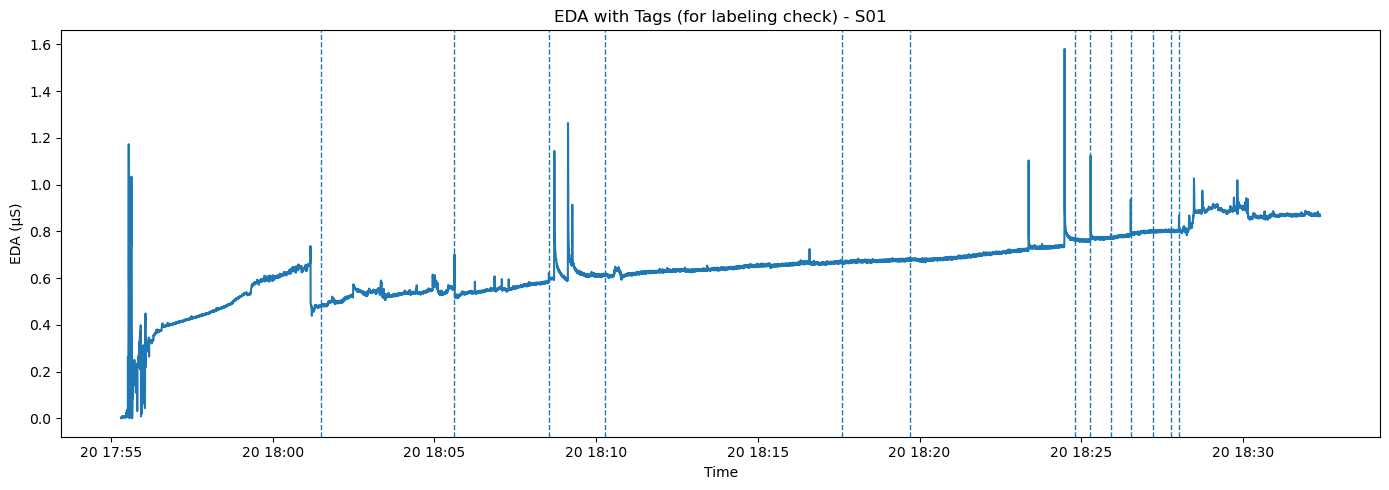

In [14]:
# simple plot to check if labels look correct

plt.figure(figsize=(14,5))
plt.plot(eda_df["time"], eda_df["eda"], label="EDA")

# draw vertical lines for tags
for t in tag_times:
    plt.axvline(t, linestyle="--", linewidth=1)

plt.title(f"EDA with Tags (for labeling check) - {subject}")
plt.xlabel("Time")
plt.ylabel("EDA (µS)")
plt.tight_layout()
plt.show()
